In [1]:
import numpy as np
from skimage import io
from skimage import img_as_float,img_as_int
import matplotlib.pyplot as plt
import pickle,os
from os.path import dirname as up

Importing all the required libraries

In [2]:
def get_primary_lobe(foc_spot,plot=0):
    cx,cy = np.round(np.where(foc_spot==np.max(foc_spot)))
    nr,nc = np.shape(foc_spot)
    r = np.arange(nr)-cx 
    c = np.arange(nc)-cy 
    [R,C] = np.meshgrid(r,c)
    index = np.round(np.sqrt(R**2+C**2))+1 
    primary_lobe = 0
    temp = np.max(foc_spot)

    for i in range(1,int(np.max(index))):
        if np.max(foc_spot[np.where(index==i)])<=temp:
            primary_lobe+=np.sum(foc_spot[np.where(index==i)]**2)
            temp=np.max(foc_spot[np.where(index==i)])
            j = i
        else :
            break
    
    if plot==1 :
        plt.imshow(foc_spot,cmap='jet')
        plt.colorbar()
        for i in range(1,j):
            R1,C1 = np.where(index==i)
            plt.scatter(C1,R1,s=5)
        plt.show()
    return primary_lobe

*get_primary_lobe* : get the sum of intensities of all points within the primary lobe. The primary lobe is located by making rings of increases radius (and noting the maximum intensity in the ring) until the intensity decreases.
* *Inputs* : focal_spot, plot - if set to 1, an image of the primary lobe is superimposed upon the focal spot
* *Outputs* : sum of intensities of pixels within the primary lobe

In [3]:
os.chdir(os.getcwd()+str('/rings'))
parameters = pickle.load(open('parameters.pickle','rb'))
step_xy = parameters['step_xy']
focal_length = parameters['focal_length']
grid_size = parameters['grid_size']
wavel = parameters['wavelength in m']
num_tilt_angles = 50
angles = np.linspace(0,1,num_tilt_angles)

Importing the parameters associated with the dataset.

In [4]:
focal_spot = []
max_intensity = np.zeros(num_tilt_angles)
primary_lobe = np.zeros(num_tilt_angles)
max_plot_value = np.zeros(num_tilt_angles)
primary_lobe_ratio = np.zeros(num_tilt_angles)
os.chdir(up(os.getcwd())+str('/output/')+str('zones_250_thickness_2e-06'))
step_xy_output = np.load('max_loc.npy')[0]['L2']/grid_size


for i in range(num_tilt_angles):
    j = angles[i]
    focal_spot_ = io.imread('tilt_'+str(j)+'.tiff')
    max_intensity[i] = np.max(focal_spot_)**2
    primary_lobe[i] = get_primary_lobe(focal_spot_)
    primary_lobe_ratio[i] = get_primary_lobe(focal_spot_)/np.sum(focal_spot_**2)
    focal_spot.append(focal_spot_)
    max_plot_value[i]= np.max(np.log(focal_spot[i]**2+1))
max_plot_value = np.max(max_plot_value)

* *focal_spot*         : list containing all the focal spots
* *max_intensity*      : array containing the maximum intensity of each focal spot
* *primary_lobe*       : array containing the sum of intensities of primary lobe of each focal spot
* *primary_lobe_ratio* : ratio of intensity in primary lobe and intensity in the focal spot
* *max_plot_value*     : related to setting the colorbar when all the spots are plotted
* *step_xy_output*     : distance between adjacent pixels in focal plane

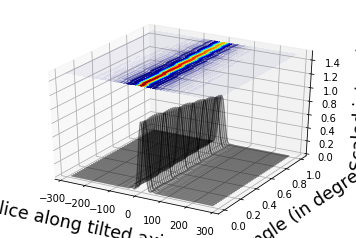

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

n = 50
x_axis = np.linspace(-n*step_xy_output,n*step_xy_output,2*n)*1e9
y = angles
Z = np.zeros((num_tilt_angles,2*n))
n_ = int(np.shape(focal_spot[i])[0]/2)
for i in range(num_tilt_angles):
    Z[i,:] = focal_spot[i][n_ ,n_-n : n_+n]**2
X,Y = np.meshgrid(x_axis,y)
Z = Z/np.max(Z)

fig = plt.figure()
ax = fig.gca(projection='3d')
z_levels = np.linspace(0.0,1.0,5000)

cset = ax.contour(X, Y, Z, zdir='y',colors='k',levels=angles,alpha = 0.5)
cset = ax.contourf(X, Y, Z, zdir='z',cmap=cm.jet,offset=1.5,levels=z_levels,alpha = 0.05)
ax.set_zlim(0,1.5)
ax.set_ylabel('Tilt angle (in degrees)',fontsize=17.5,labelpad = 10)
ax.set_xlabel('Slice along tilted axis (in nm)',fontsize=17.5,labelpad = 10)
ax.set_zlabel('Scaled intensity',fontsize=17.5,labelpad = 10)
plt.rcParams["figure.figsize"] = (12,12)
plt.show()

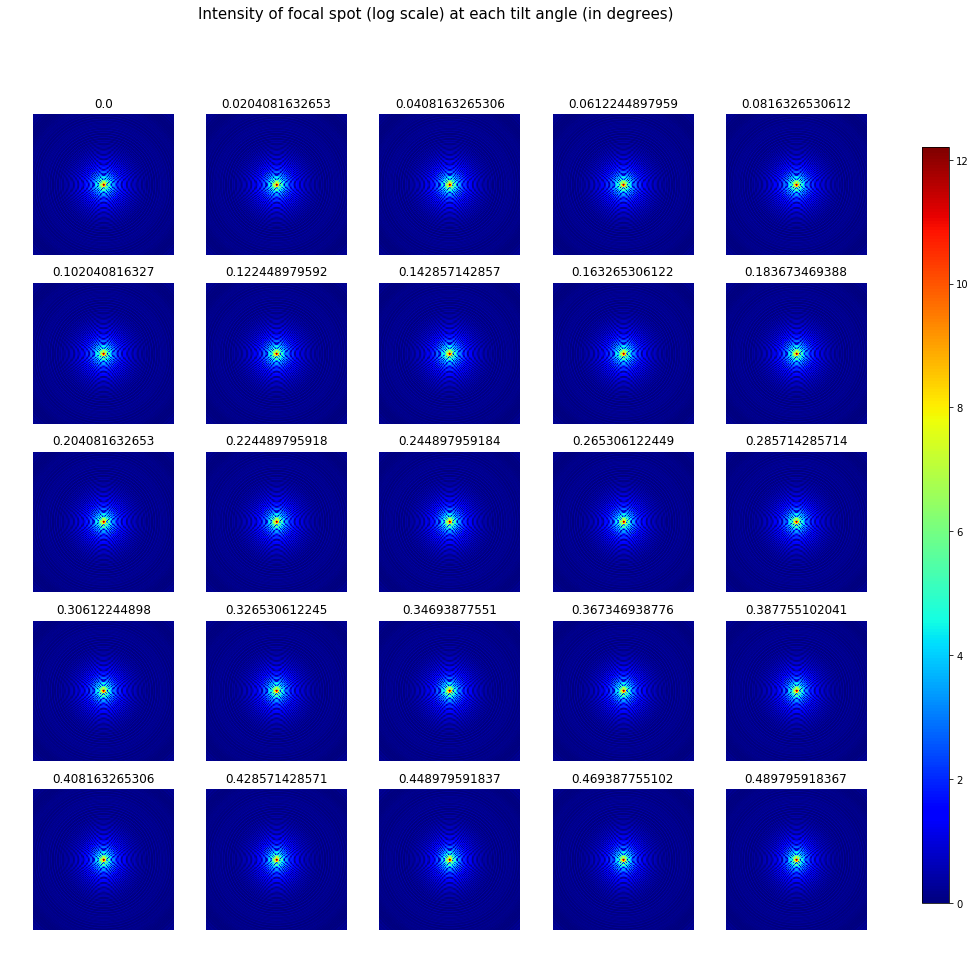

In [6]:
plt.clf()
f, axarr = plt.subplots(5,5)
k = 0
axis = []
    
for i in range(5):
    for j in range(5):
        im = axarr[i,j].imshow(np.log(focal_spot[k]**2+1),vmin = 0,vmax = max_plot_value,cmap = 'jet')
        axarr[i,j].axis('off')
        axarr[i,j].set_title(angles[k])
        axarr[i,j].title.set_y(1.01)
        axis.append(angles[k])
        k = k+1

cbar_ax = f.add_axes([0.95, 0.15, 0.025, 0.7])
f.colorbar(im, cax=cbar_ax)
f.set_size_inches(15, 15, forward=True)
f.subplots_adjust(wspace=0.2)
f.subplots_adjust(hspace=0.2)
f.suptitle('Intensity of focal spot (log scale) at each tilt angle (in degrees)',fontsize = 15)
plt.show()

An overview of all the focal spots!

In [7]:
rel_intensity = (max_intensity)/(np.max(max_intensity))
rel_primary_lobe = (primary_lobe)/(np.max(primary_lobe))
shift_pred = focal_length*np.tan(angles*(np.pi/180))
max_loc = [list(map(lambda x: x['max_loc'],np.load('max_loc.npy')))]
max_loc = np.array(max_loc)

* *rel_intensity*    : normalize max_intensity to 1 for plotting 
* *rel_primary_lobe* : normalize primary_lobe to 1 for plotting 
* *shift_pred*       : predicted shift of focal spot
* *max_loc*          : actual shift of focal spot as measured by the location of maxima in output wavefront

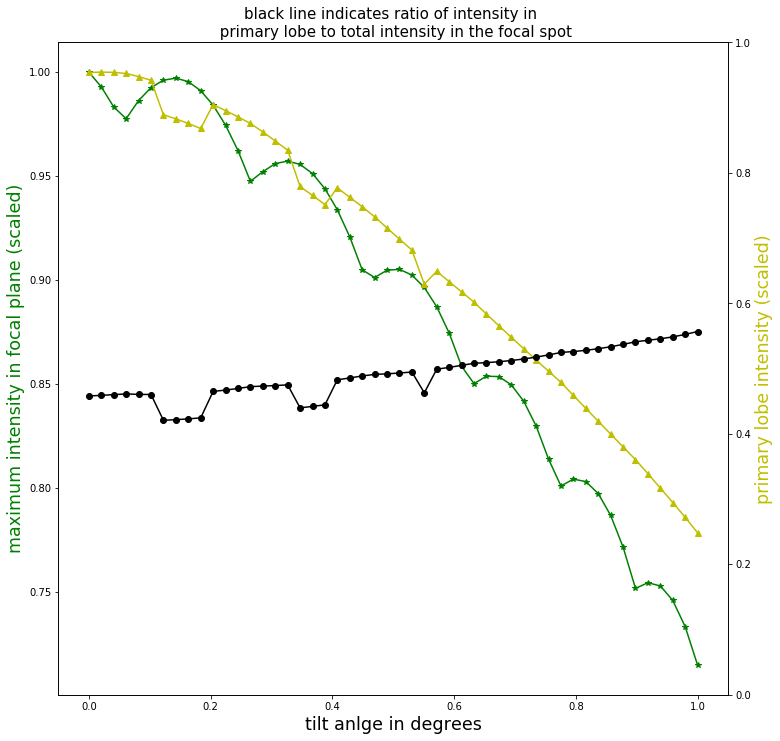

In [8]:
scaling = 6
f,ax1 = plt.subplots(1,1)
ax1.plot(angles,rel_intensity,'g*-')
ax1.plot(angles,rel_primary_lobe,'y^-')
ax1.plot(angles,primary_lobe_ratio,'ko-')
ax1.set_ylabel('maximum intensity in focal plane (scaled)',color='g',fontsize=17.5)
ax1.set_xlabel('tilt anlge in degrees',fontsize=17.5)
ax2 = ax1.twinx()
ax2.set_ylabel('primary lobe intensity (scaled)',color='y',fontsize=17.5)
plt.title('black line indicates ratio of intensity in \n primary lobe to total intensity in the focal spot',fontsize=15)
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['xtick.labelsize'] = 10 
plt.rcParams['ytick.labelsize'] = 10
plt.show()

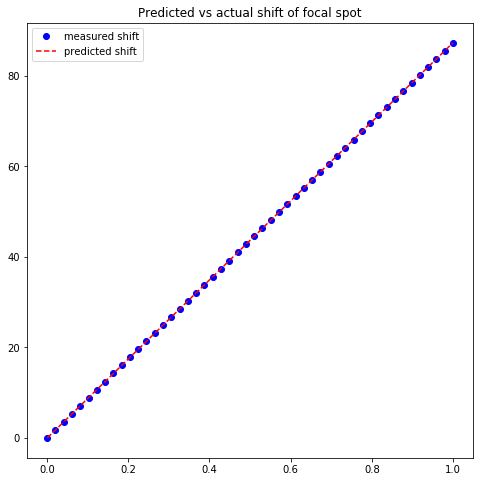

In [9]:
scaling  = 6
plt.plot(angles,((max_loc[0][:,1]-int(grid_size/2))*step_xy_output)*10**(scaling),'bo',label = 'measured shift')
plt.plot(angles,shift_pred*10**(scaling),'r--',label='predicted shift')
plt.legend()
plt.title('Predicted vs actual shift of focal spot')
plt.show()

This is a sanity check to make sure we are not losing the focal spot. (in the sense that it's not falling off the edge of the array)

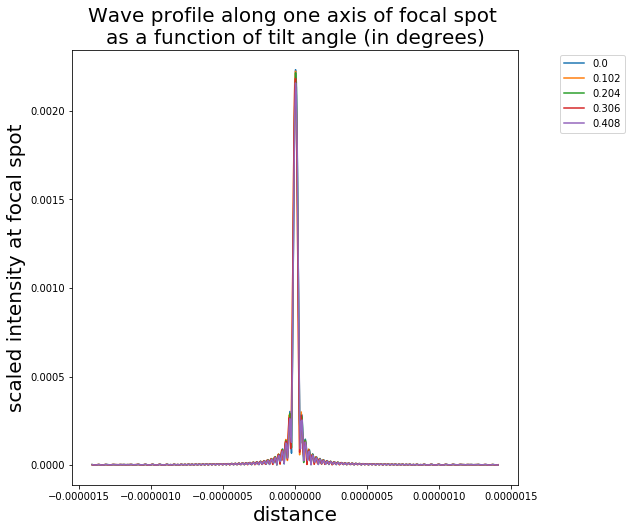

In [10]:
x_axis = np.linspace(-250*step_xy_output,250*step_xy_output,500)
max_loc_of_set = np.where(max_intensity==np.max(max_intensity))[0]
scaling = max_intensity[max_loc_of_set[0]]

for i in range(25):
    if i%5==0:
        focal_spot_profile = focal_spot[i][int(np.shape(focal_spot[i])[0]/2),:]/scaling
        plt.plot(x_axis,focal_spot_profile,label=str(round(angles[i],3)))
plt.legend(bbox_to_anchor=(1.25,1))
plt.rcParams["figure.figsize"] = (8,8)
plt.xlabel('distance',fontsize = 20)
plt.ylabel('scaled intensity at focal spot',fontsize = 20)
plt.title('Wave profile along one axis of focal spot '+'\n'+'as a function of tilt angle (in degrees)',fontsize = 20)
plt.show()

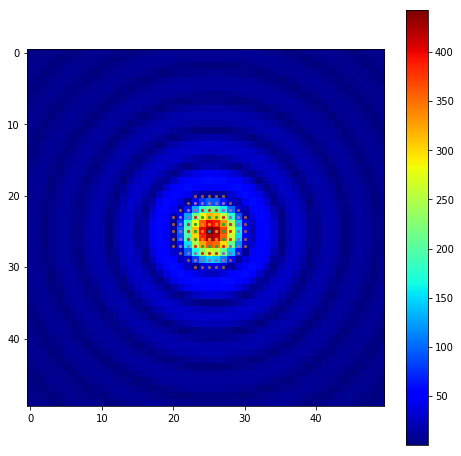

4228675.3842200208

In [11]:
get_primary_lobe(focal_spot[11][250-25:250+25,250-25:250+25],plot=1)

Visual confirmation that the pixels in the primary lobe are indeed being selected.

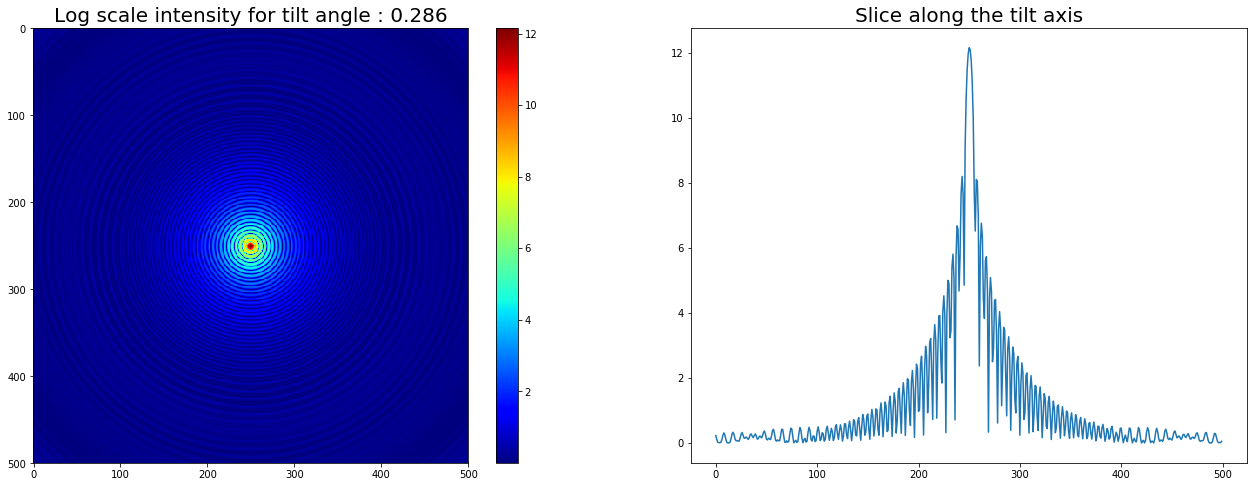

In [12]:
i = 14
var = np.log(focal_spot[i]**2+1)
f,(ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow((var),cmap='jet')
f.colorbar(im1,ax=ax1)
im2 = ax2.plot(var[:,int(np.shape(focal_spot[i])[0]/2)])
f.subplots_adjust(right=2.25)
ax1.set_title('Log scale intensity for tilt angle : '+ str(round(angles[i],3)),fontsize = 20)
ax2.set_title('Slice along the tilt axis', fontsize = 20)
plt.show()